In [1]:
import pandas as pd
import numpy
import scipy.stats as sts
from scipy.optimize import curve_fit
import scipy.ndimage as snd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
df = pd.read_csv('/home/dprotter/Downloads/testing_fiji/output_from_macro.csv')

In [3]:
num_cells = len(df.columns) - 3

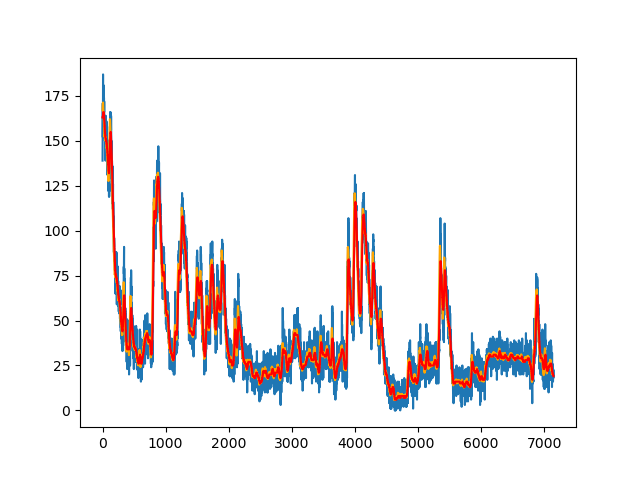

In [4]:

window = 20
def moving_average(x, w):
    """calculate moving average with window size w"""
    return np.convolve(x, np.ones(w), 'valid') / w
fig, ax = plt.subplots()
data = df['y0']
ax.plot(data)
ax.plot(moving_average(data, window), color  = 'orange')
gaus = snd.gaussian_filter1d(data, 10)
ax.plot(gaus, color = 'red')


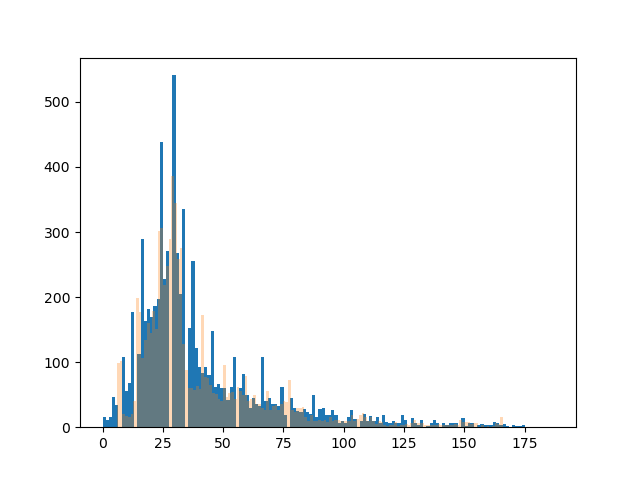

In [5]:
plt.figure()
_=plt.hist(data, bins = int(len(data)/50))
bins=plt.hist(gaus, bins = int(len(data)/50), alpha = 0.3)


In [6]:
bins[1].max()

166.0

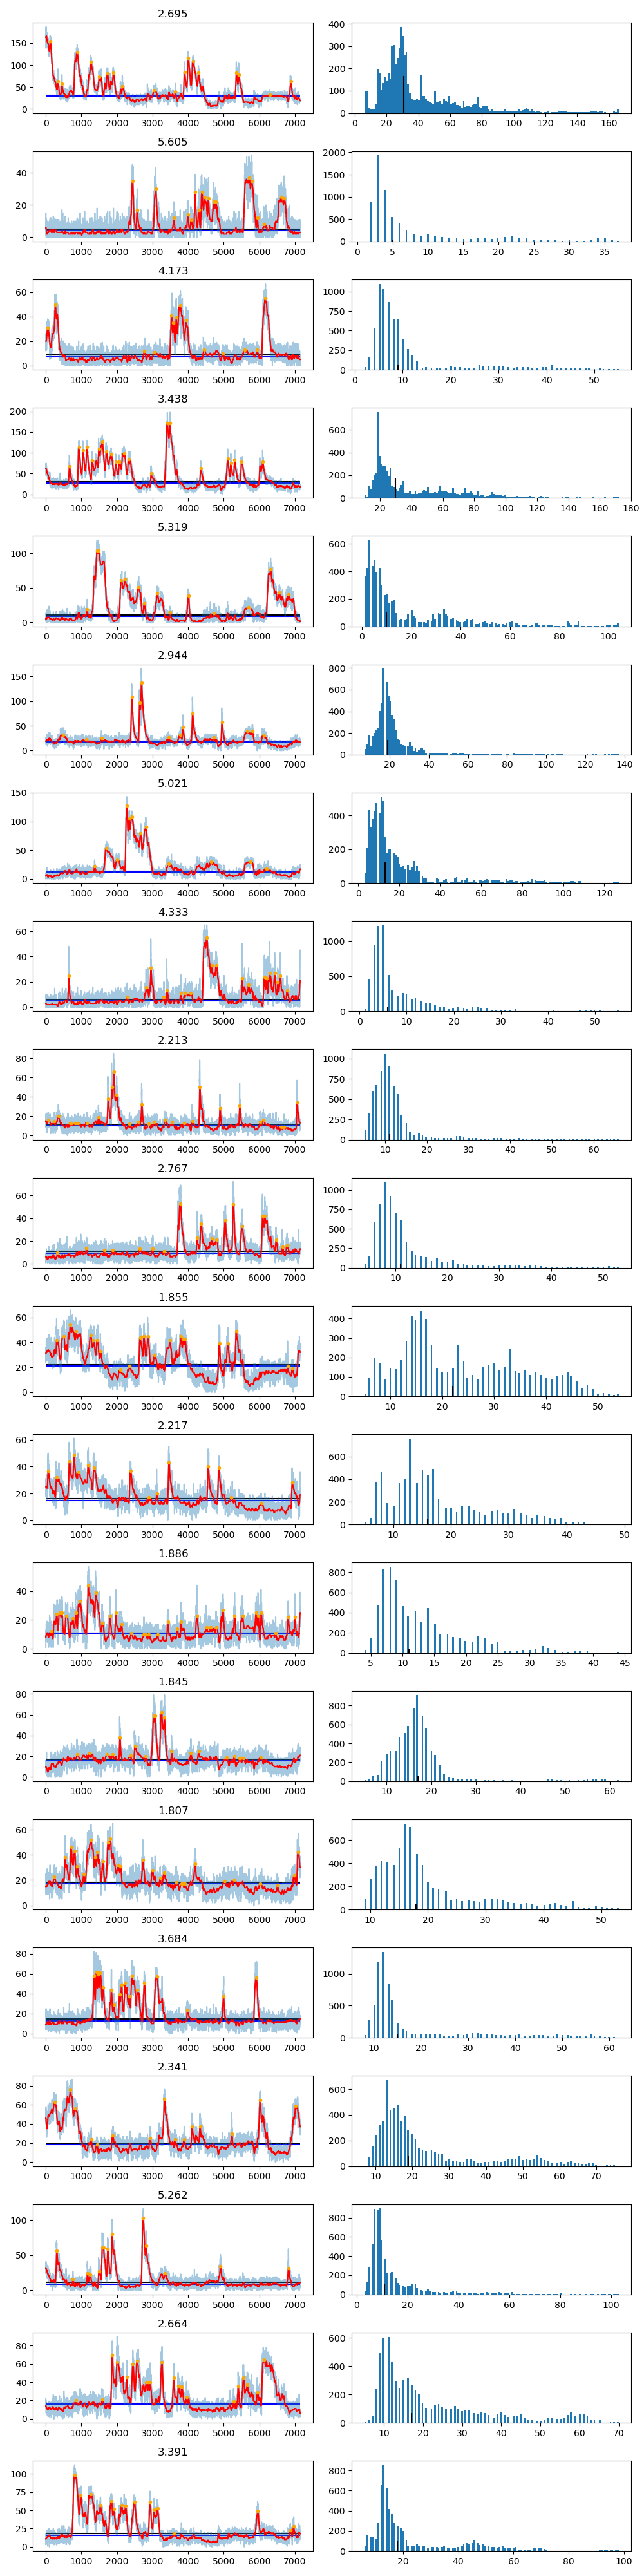

In [7]:
import scipy.signal as sig
fig, axs = plt.subplots(ncols=2, nrows = 20, figsize = (10, 40))
for i in range(20):
    data = df[f'y{i}']
    med = np.median(data)
    axs[i, 0].plot(data, alpha = 0.4)
    gaus = snd.gaussian_filter1d(data, 10)
    med_gaus = np.median(gaus)
    gaus_std = np.std(gaus)
    peaks = sig.find_peaks(gaus,prominence=gaus_std/2)
    axs[i, 0].plot(gaus, color = 'red')
    axs[i,0].hlines(y = med, xmin = 0, xmax = len(data), color = 'black')
    axs[i,0].hlines(y = med_gaus, xmin = 0, xmax = len(data), color = 'blue')
    axs[i,0].scatter(x = peaks[0], y = gaus[peaks[0]], color = 'orange', marker = '.',zorder = 3)
    
    mean_snr = np.mean(gaus[peaks[0]]/med_gaus)
    
    axs[i,0].set_title(np.round(mean_snr,3))
    
    bins = axs[i, 1].hist(gaus, bins = int(len(data)/50))
    
    axs[i,1].vlines(x = med, ymin = 0, ymax = bins[1].max(), color = 'black')
fig.tight_layout()

In [45]:
len(peaks[-1])

3

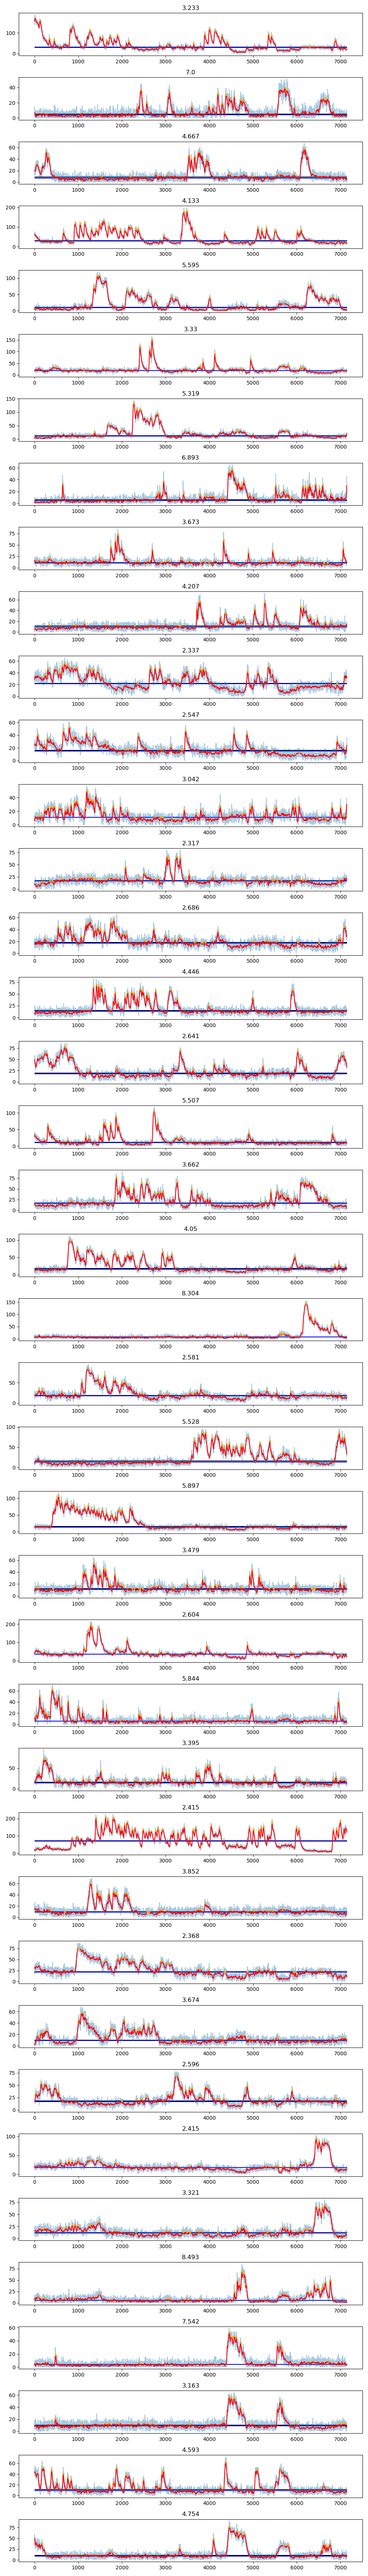

In [68]:
import scipy.signal as sig
fig, axs = plt.subplots(ncols=1, nrows = 40, figsize = (10, 70))

cells = {}
cell_peaks ={}
decay_fit_window = 40
for i in range(num_cells):
    data = df[f'y{i}']
    med = np.median(data)
    axs[i].plot(data, alpha = 0.4)
    gaus = snd.gaussian_filter1d(data, 5)
    med_gaus = np.median(gaus)
    gaus_std = np.std(gaus)
    peaks = sig.find_peaks(gaus,prominence=gaus_std/1.5)
    axs[i].plot(gaus, color = 'red')
    axs[i].hlines(y = med, xmin = 0, xmax = len(data), color = 'black')
    axs[i].hlines(y = med_gaus, xmin = 0, xmax = len(data), color = 'blue')
    axs[i].scatter(x = peaks[0], y = gaus[peaks[0]], color = 'orange', marker = '.',zorder = 3)
    
    peak_vals = gaus[peaks[0]]
    peak_vals = sorted(peak_vals, reverse=True)
    mean_snr = np.mean(np.mean(peak_vals[:15])/med_gaus)
    
    axs[i].set_title(np.round(mean_snr,3))
    max_peak = np.max(gaus[peaks[0]])
    decay_curves = np.zeros((len(peaks[0]), 40))
    
    drop_list = []
    for j, peak in enumerate(peaks[0]):
        
        #decay window
        if peak+decay_fit_window > len(gaus):
            drop_list += [j]
        else:
            decay_curves[j,:] = gaus[peak:peak+40]
        
    
    peaks_out_dict = {}
    #remove any peaks/decay data that is too close to the end (maybe this should be a variable?)   
    if len(drop_list)>0:
        decay_curves = decay_curves[:min(drop_list),:]
        peaks_out = peaks[0][:min(drop_list)]

        for key in peaks[1].keys():
            peaks_out_dict[key] = peaks[1][key][:min(drop_list)]
    else:
        peaks_out_dict = peaks[1]
    
    cells[i] = decay_curves  
    cell_peaks[i] = (peaks_out, peaks_out_dict)
fig.tight_layout()

In [75]:
# create our dataset for fitting
cells_decay_curves = {}
cell_peaks ={}
decay_fit_window = 30
gaus_smooth_factor = 5


for i in range(num_cells):
    data = df[f'y{i}']
    med = np.median(data)
    gaus = snd.gaussian_filter1d(data, gaus_smooth_factor)
    med_gaus = np.median(gaus)
    gaus_std = np.std(gaus)
    peaks = sig.find_peaks(gaus,prominence=gaus_std/1.5)

    decay_curves = np.zeros((len(peaks[0]), decay_fit_window))
    
    drop_list = []
    for j, peak in enumerate(peaks[0]):
        
        #decay window
        if peak+decay_fit_window > len(gaus):
            drop_list += [j]
        else:
            decay_curves[j,:] = gaus[peak:peak+decay_fit_window]
    
    peaks_out_dict = {}
    #remove any peaks/decay data that is too close to the end
    if len(drop_list)>0:
        print(f'drop_list {drop_list}')
        decay_curves = decay_curves[:min(drop_list),:]
        peaks_out = peaks[0][:min(drop_list)]

        for key in peaks[1].keys():
            peaks_out_dict[key] = peaks[1][key][:min(drop_list)]
    else:
        peaks_out = peaks[0]
        peaks_out_dict = peaks[1]
    
    cells_decay_curves[i] = decay_curves  
    cell_peaks[i] = (peaks_out, peaks_out_dict)



In [32]:
def half_life(t , initial, t_one_half):  
    return initial * np.power(0.5, (t/t_one_half))

In [33]:
half_life(np.asarray([0,1,2,3]), 173, 5)

array([173.        , 150.60524745, 131.109483  , 114.13743428])

In [34]:
def plot_decay(params, peak_loc, axes_obj, window = 20, color = 'green', alpha = 0.8):
    initial_height, t_half = params
    xs = np.asarray([x for x in range(window)])
    ys = half_life(xs, initial_height, t_half)
    plt_xs = xs + peak_loc
    axes_obj.plot(plt_xs, ys, color = color, alpha = alpha)
    return axes_obj
    

array([  73,  106,  213,  236,  292,  373,  514,  576,  697,  815,  876,
       1113, 1241, 1405, 1514, 1749, 1808, 2096, 2322, 2347, 2509, 2678,
       2832, 2929, 3012, 3079, 3357, 3452, 3625, 3699, 3759, 3909, 3959,
       4015, 4233, 4446, 4674, 4853, 5011, 5244, 5286, 5299, 5383, 5506,
       5983, 6051, 6233, 6837, 6895, 7032])

In [77]:
cell = 10
print(f'{len(cells_decay_curves[cell])} : {len(cell_peaks[cell][0])}')

31 : 31


In [84]:
pcov

array([[ 0.21686847, -0.69053258],
       [-0.69053258,  3.15878827]])

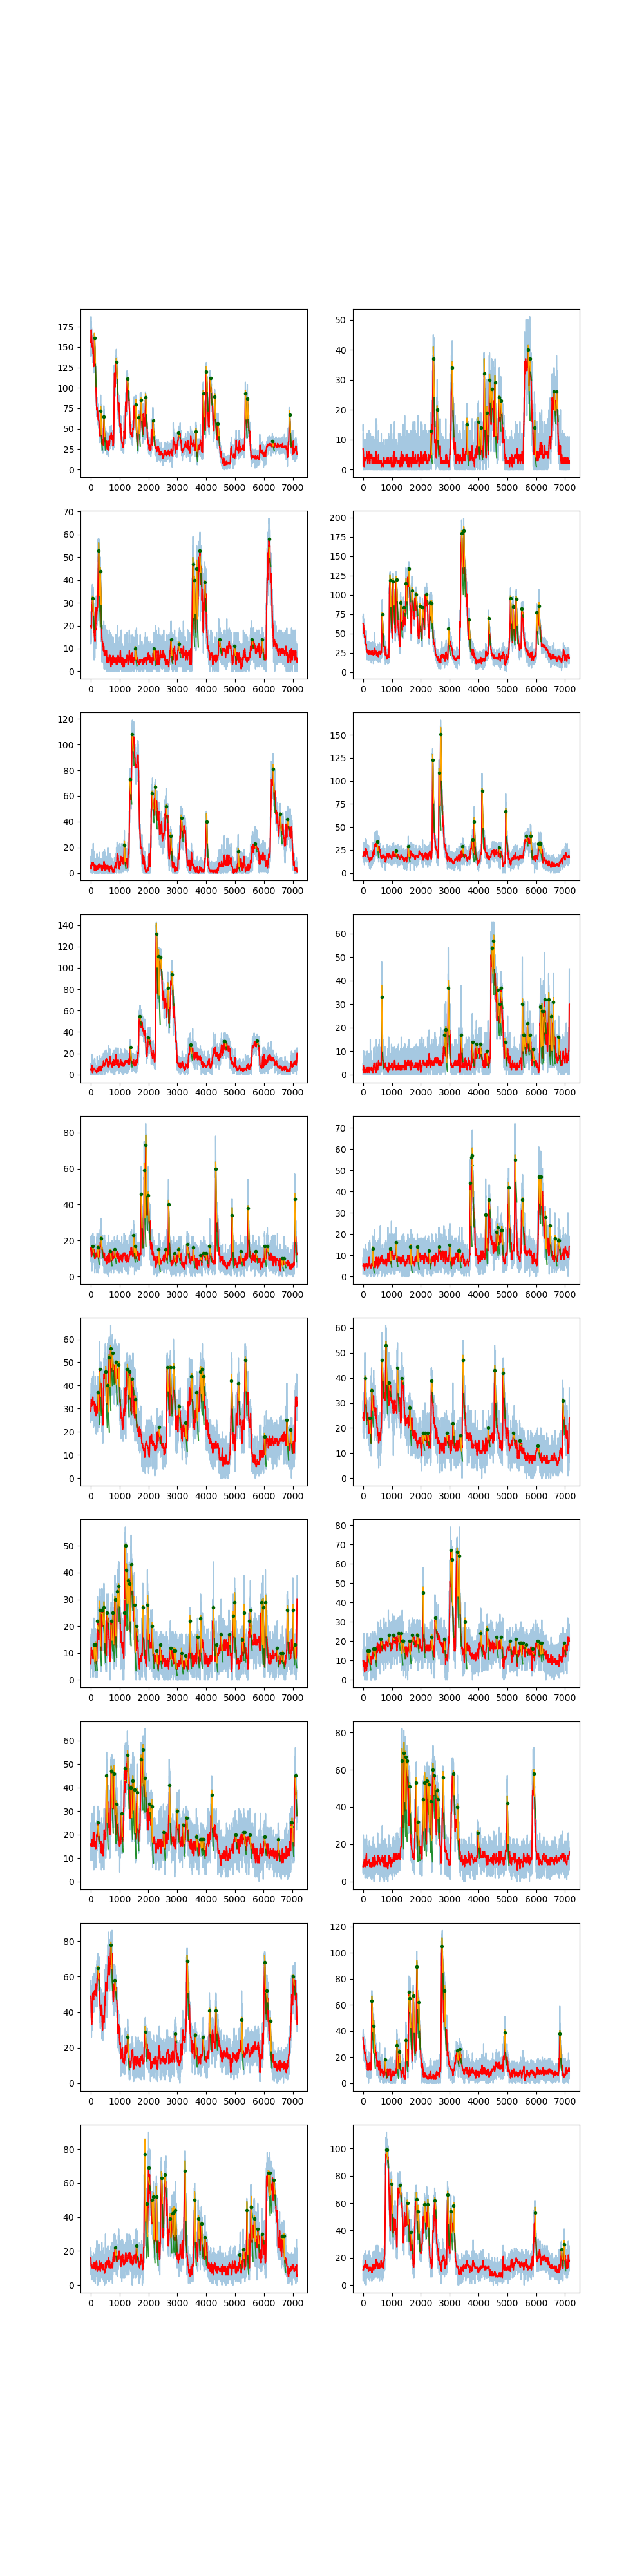

In [78]:
%matplotlib notebook
fig, axs = plt.subplots(ncols=2, nrows = 10, figsize = (10, 40))
fit_window = 30
cell_params = {}






for cell, ax in zip(cells_decay_curves.keys(), axs.ravel()):

    #cell peaks contains a list of peaks and a dict
    peak_locs = cell_peaks[cell][0]
    
    params = np.zeros((len(cells_decay_curves[cell]),2))
    xdata = [x+1 for  x in range(fit_window)]

    for i, decay in enumerate(cells_decay_curves[cell]):
        #initial guesses [initial height, t_half]
        p0  = [decay[0], 1]
        popt, pcov = curve_fit(half_life, xdata, cells_decay_curves[cell][i][:fit_window], p0 = p0)
        params[i,:] = popt
    cell_params[cell] = params
    # residuals = np.zeros((len(cells[cell]), len(cells[cell][0])))


    data = df[f'y{cell}']
    med = np.median(data)
    ax.plot(data, alpha = 0.4)
    gaus = snd.gaussian_filter1d(data, gaus_smooth_factor)
    
    ax.plot(gaus, color = 'red')
    ax.scatter(x = peak_locs, y = gaus[peak_locs], color = 'darkgreen', marker = '.',zorder = 3)

    for param_pair, peak_loc in zip(params, peak_locs):
        ax = plot_decay(param_pair, peak_loc, ax, window = 60)
        ax = plot_decay(param_pair, peak_loc, ax, window = fit_window, color = 'orange', alpha = 1)


In [17]:
decay

171.0

In [62]:
cell_params

{0: array([[173.58055382, 148.53441385],
        [166.49340821,  82.58479618],
        [ 76.46622073,  35.50486572],
        [ 66.21725849,  40.29024959],
        [ 44.45287392,  92.56180191],
        [117.60388217, 136.34781796],
        [135.54183031, 106.24145093],
        [112.78416637, 144.6459573 ],
        [ 80.56655834,  82.9785673 ],
        [ 85.56368723,  31.65831238],
        [ 67.00421851,  48.21409114],
        [ 87.55579143,  53.71306728],
        [ 68.71991043, 110.29835474],
        [ 91.82839627,  68.91011819],
        [ 53.22474891,  40.9339009 ],
        [ 57.74289375,  61.54638258],
        [ 37.39318374,  90.1147866 ],
        [ 44.4839927 , 265.89524   ],
        [ 41.97701024,  60.29064663],
        [ 50.42344267,  24.89128884],
        [ 35.41077593, 185.2634978 ],
        [ 96.04512177,  50.63934895],
        [125.92723464,  73.05544788],
        [112.26698497, 117.5938481 ],
        [ 91.84768922,  52.70976886],
        [ 57.69898059,  62.17375889],
        [


[[ 1.35481084e-01 -1.20966673e+01]
 [-1.20966673e+01  1.42075487e+03]]


[[ 1.05956893e-01 -1.51055252e+01]
 [-1.51055252e+01  2.82908856e+03]]


[[ 0.37597795 -2.5613996 ]
 [-2.5613996  23.50634276]]


[[ 2.30738563e-01 -7.19358123e+00]
 [-7.19358123e+00  2.95755864e+02]]


[[ 7.58816057e-02 -6.91961388e+00]
 [-6.91961388e+00  8.27026997e+02]]


[[ 0.18321148 -2.50068845]
 [-2.50068845 45.32523607]]


[[ 4.96525129e-02 -1.27230504e+01]
 [-1.27230504e+01  4.26735314e+03]]


[[ 9.36544141e-02 -4.28447470e+00]
 [-4.28447470e+00  2.59435904e+02]]


[[ 5.75273180e-02 -3.22274053e+08]
 [-3.22274053e+08  2.35011450e+18]]


[[ 5.46366602e-02 -2.12094025e+00]
 [-2.12094025e+00  1.09230635e+02]]


[[ 2.08300584e-02 -1.02650561e+00]
 [-1.02650561e+00  6.75705560e+01]]


[[ 1.92569453e-02 -2.58255942e+00]
 [-2.58255942e+00  4.58436306e+02]]


[[  0.94569466 -14.44577127]
 [-14.44577127 294.01360069]]


[[ 8.01969271e-02 -1.11311995e+01]
 [-1.11311995e+01  2.03563371e+03]]


[[ 3.71621740e-02 -3.

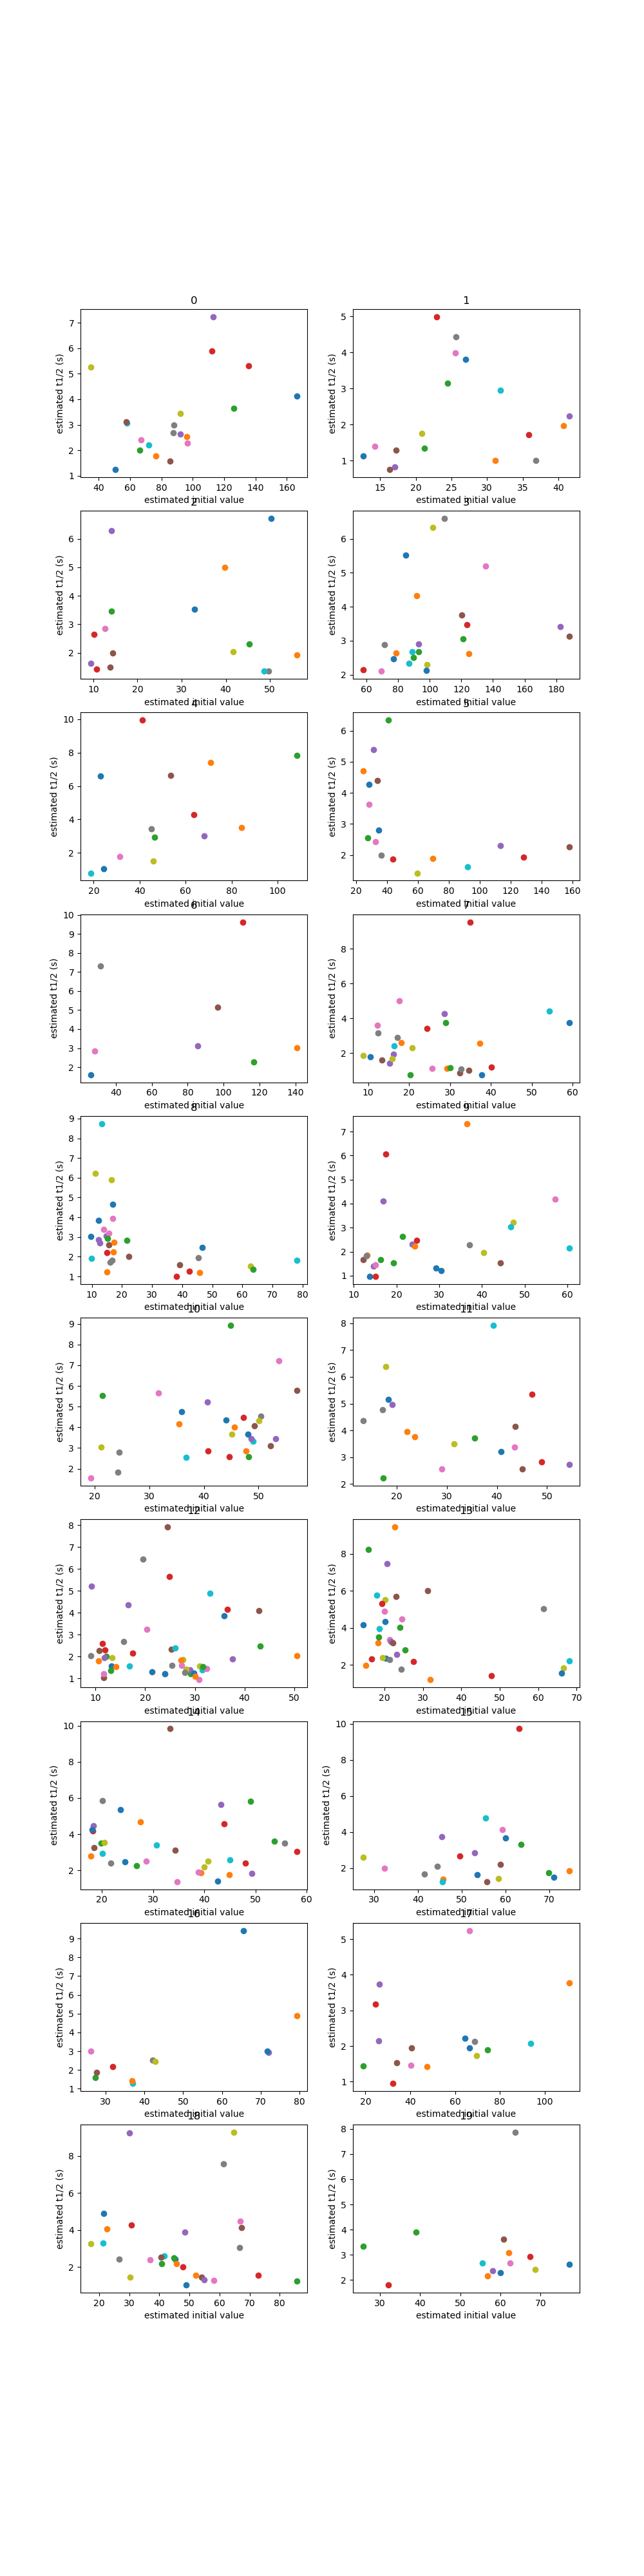

In [93]:
fig, axs = plt.subplots(ncols=2, nrows = 10, figsize = (10, 40))
fit_window = 20
for cell, ax in zip(cells_decay_curves.keys(), axs.ravel()):
    for i, param_pair in enumerate(cell_params[cell]):
        
        if param_pair[1] > 10*20:
            xdata = [x+1 for  x in range(fit_window)]
            popt, pcov = curve_fit(half_life, xdata, cells_decay_curves[cell][i][:fit_window], p0 = p0)
            print()
            print(pcov)
            print()
        elif  param_pair[1] > 0:
            ax.scatter(param_pair[0], param_pair[1]/20)
            ax.set_xlabel('estimated initial value')
            ax.set_ylabel('estimated t1/2 (s)')
            ax.set_title(cell)
        else:
            continue


In [83]:
cell_params[12]

array([[1.31829224e+01, 3.13153344e+01],
       [1.41054536e+01, 3.08372357e+01],
       [2.01131531e+01, 3.45257193e+02],
       [2.92178936e+01, 2.40913762e+01],
       [2.48630596e+01, 4.22896971e+03],
       [2.48170522e+01, 1.13016946e+02],
       [2.89865006e+01, 2.75591736e+01],
       [2.45272723e+01, 1.58185180e+02],
       [2.03335417e+01, 6.46333807e+01],
       [2.53775303e+01, 3.17526001e+01],
       [3.10068927e+01, 3.15747302e+01],
       [3.30905176e+01, 9.76588969e+01],
       [3.58679735e+01, 7.71372298e+01],
       [2.98333335e+01, 1.61181051e+09],
       [5.05863853e+01, 4.07146709e+01],
       [4.31585561e+01, 4.95308294e+01],
       [3.65903330e+01, 8.30043945e+01],
       [3.75430931e+01, 3.79057488e+01],
       [4.28633865e+01, 8.19406918e+01],
       [3.08516957e+01, 1.86865309e+01],
       [1.95758672e+01, 1.29189419e+02],
       [2.75912978e+01, 3.73613727e+01],
       [3.15488781e+01, 2.77268980e+01],
       [2.13112940e+01, 2.57972001e+01],
       [1.057411

In [88]:
param_arr[:,1]

array([ 1.48534414e+02, -7.12921093e+09,  3.55048673e+01,  4.02902582e+01,
        9.25617770e+01,  1.36347890e+02,  1.06241450e+02,  1.44645959e+02,
        8.29785667e+01,  3.16583126e+01,  4.82140933e+01,  5.37130661e+01,
        1.10298359e+02,  6.89101187e+01,  4.09339121e+01,  6.15463428e+01,
        9.01148053e+01,  2.65895261e+02,  6.02906469e+01, -1.27362055e+09,
        1.85263498e+02,  5.06393490e+01,  7.30554682e+01,  1.17593853e+02,
        5.27097682e+01, -7.57683498e+09,  5.84374547e+01,  4.58496158e+01,
        5.99057377e+01,  1.05371337e+02,  4.40642540e+01,  3.10911607e+01])

In [90]:
param_slice

array([[16.34116244, 14.95299546]])

KeyError: 20

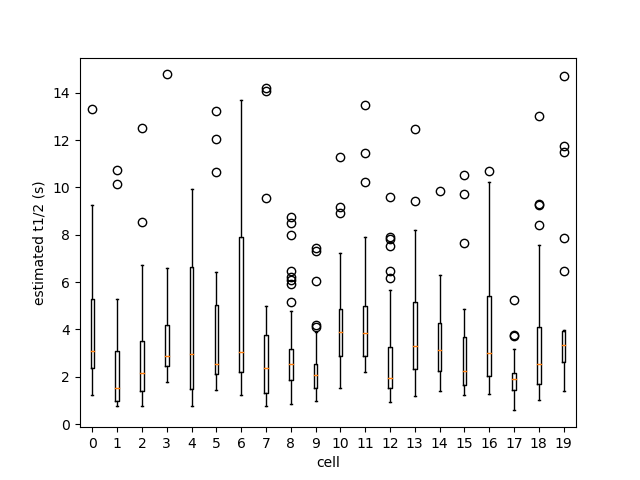

In [108]:
fig, ax = plt.subplots()
fit_window = 20
for cell in cells.keys():
    param_arr = cell_params[cell]
    param_arr[:,1] = param_arr[:,1]/20
    param_slice = param_arr[np.logical_and(param_arr[:,1] > 0, param_arr[:,1] < 15)]
    if len(param_slice>0):
        ax.boxplot(x = param_slice[:,1], positions=[cell])
        ax.set_xlabel('cell')
        ax.set_ylabel('estimated t1/2 (s)')


In [ ]:
fig, axs = plt.subplots(ncols=2, nrows = 20, figsize = (10, 40))

cells = {}

for i in range(0):
    data = df[f'y{i}']
    med = np.median(data)
    axs[i, 0].plot(data, alpha = 0.4)
    gaus = snd.gaussian_filter1d(data, 5)
    med_gaus = np.median(gaus)
    gaus_std = np.std(gaus)
    peaks = sig.find_peaks(gaus,prominence=gaus_std/2)
    axs[i, 0].plot(gaus, color = 'red')
    axs[i,0].hlines(y = med, xmin = 0, xmax = len(data), color = 'black')
    axs[i,0].hlines(y = med_gaus, xmin = 0, xmax = len(data), color = 'blue')
    axs[i,0].scatter(x = peaks[0], y = gaus[peaks[0]], color = 'orange', marker = '.',zorder = 3)
    
    mean_snr = np.mean(gaus[peaks[0]]/med_gaus)
    
    axs[i,0].set_title(np.round(mean_snr,3))
    max_peak = np.max(gaus[peaks[0]])
    decay_curves = np.zeros((len(peaks[0]), 40))
    for j, peak in enumerate(peaks[0]):
        decay_curves[j,:] = gaus[peak:peak+40]
        axs[i,1].plot(gaus[peak:peak+20])
    cells[i] = decay_curves  
fig.tight_layout()

<ipython-input-90-6bf32a6cca04>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


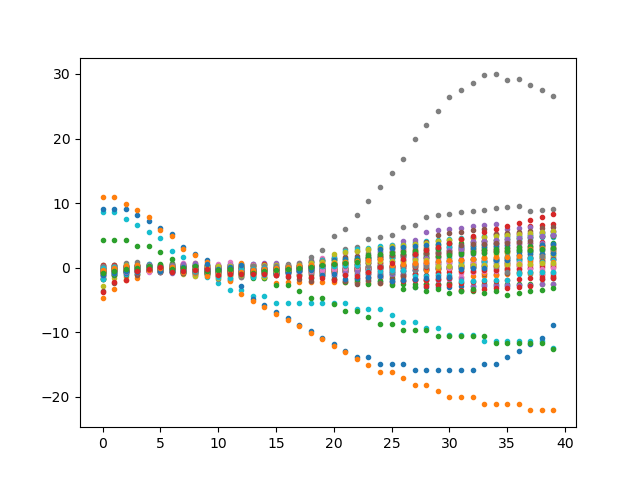

In [90]:
fig, ax = plt.subplots()
_ = [ax.plot(residual, '.') for residual in residuals]

In [128]:
df = pd.read_csv('/home/dprotter/testmount/Yurika/Meadow NAc Implants Cohort 5/2024_10_02/13_52_04/My_V4_Miniscope/ROI_traces.csv')


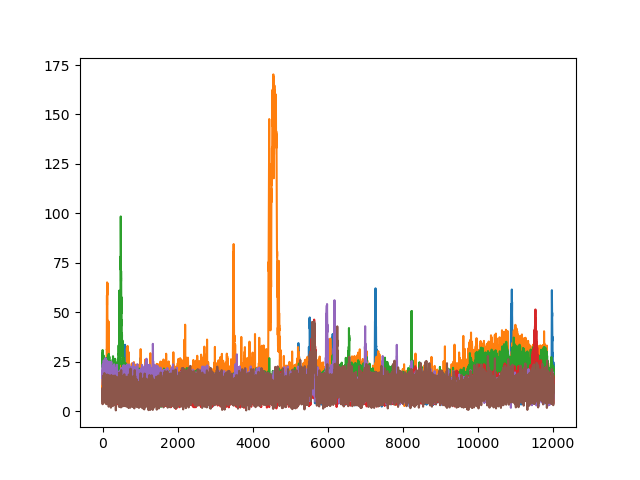

In [133]:
%matplotlib notebook
plt.figure()
df['y0'].plot()
df['y1'].plot()
df['y2'].plot()
df['y3'].plot()
df['y5'].plot()
df['y6'].plot()